## Improving Water Consumption Management in Barcelona through Data Quality Enhancement and Prediction Models
#### **TFG 2023-2024**
#### **Author: Edith Ruiz Macià**

### Analysis of dataset Dataset1_activitat_eco_v2.csv

### **About the Notebook**

The aim of this notebook (.ipynb) is to analyze and modify the dataset dataset1_activitat_eco_v2.csv provided by Aigües de Barcelona in order to improve the quality of the data and learn its insights through its visualization.

The code is structured in different levels.

1. Given the database, we start with an Exploratory Data Analysis that will provide us a general knowledge of how the raw data looks like.
2. Then, an intensive data cleaning will be applied which will transform the data and handle null, negative, and outlier values.
3. We will enhance the data by adding columns that will add up to the understanding of the data and also, by combining outside data that might be relevant to ours.
4. In order to have a complete dataset we will make a projection of absent or incorrect values previously detected in section 2. To do so, we will test several algorithms and see with which one we obtain better results.
5. Anomalies that were previously discarded and substituted by projected values with our predictive model must also be taken into account and analyzed. That is why we will classify and visualize them.

Finally, the updated resulting database can be downloaded in order to be used in other programs or other purposes of the user.

#### ***Execution time***
bla bla bla

#### ***How to execute the code***
This is a Python Notebook, so the code should be run either cell by cell or by running all the notebook at once. At the beginning, review and make sure the paths to all datasets are correct for your folders' distribution in order for everything to run smoothly.


#### ***Libraries and packages used in the project***
bla bla bla

In [1]:
# In case you are working in google colab you can mount your google drive account here
# from google.colab import drive
# drive.mount('/content/drive')

## 0. Importing datasets and libraries

In [2]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [3]:
# Change your path of the data if necessary
dataset_1_act_eco = 'C:/Users/edith/Desktop/TFG/Datasets/Aigües de Barcelona/Sets-de-dades/dataset1_activitat_eco_v2.csv'
dataset_1_act_eco = pd.read_csv(dataset_1_act_eco)
dataset_1_act_eco.head()

,Districte/Distrito/District,Codi postal/Código postal/Postcode,Municipi/Municipio/Municipality,Data/Fecha/Date,Ús/Uso/Use,Tipus d'activitat econòmica/Tipo de actividad económica/Type of economic activity,Nombre de comptadors/Número de contadores/Number of meters,Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)
0,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,1.0
1,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0
2,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,84.0
3,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0
4,NaN,8001,BARCELONA,2019-01-03,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,134.0


## 1. Exploratory Data Analysis

As a starting point, we need to explore the data. We analyze the summary of descriptive statistics and plots for each of the datasets in order to detect the corresponding anomalies and subsequently process them correctly.

In [4]:
dataset_1_act_eco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20495388 entries, 0 to 20495387
Data columns (total 8 columns):
 #   Column                                                                             Dtype  
---  ------                                                                             -----  
 0   Districte/Distrito/District                                                        float64
 1   Codi postal/Código postal/Postcode                                                 int64  
 2   Municipi/Municipio/Municipality                                                    object 
 3   Data/Fecha/Date                                                                    object 
 4   Ús/Uso/Use                                                                         object 
 5   Tipus d'activitat econòmica/Tipo de actividad económica/Type of economic activity  object 
 6   Nombre de comptadors/Número de contadores/Number of meters                         int64  
 7   Consum acumulat (

In [5]:
dataset_1_act_eco.describe()

,Districte/Distrito/District,Codi postal/Código postal/Postcode,Nombre de comptadors/Número de contadores/Number of meters,Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)
count,2.019081e+07,2.049539e+07,2.049539e+07,2.049539e+07
mean,4.109745e+00,8.255526e+03,3.539717e+00,2.048457e+03
std,2.840611e+00,3.930091e+02,1.087388e+01,2.060644e+05
min,1.000000e+00,8.001000e+03,1.000000e+00,-4.154402e+08
25%,2.000000e+00,8.013000e+03,1.000000e+00,2.500000e+01
50%,3.000000e+00,8.026000e+03,1.000000e+00,1.560000e+02
75%,6.000000e+00,8.840000e+03,3.000000e+00,6.470000e+02
max,1.000000e+01,8.980000e+03,3.940000e+02,4.151876e+08


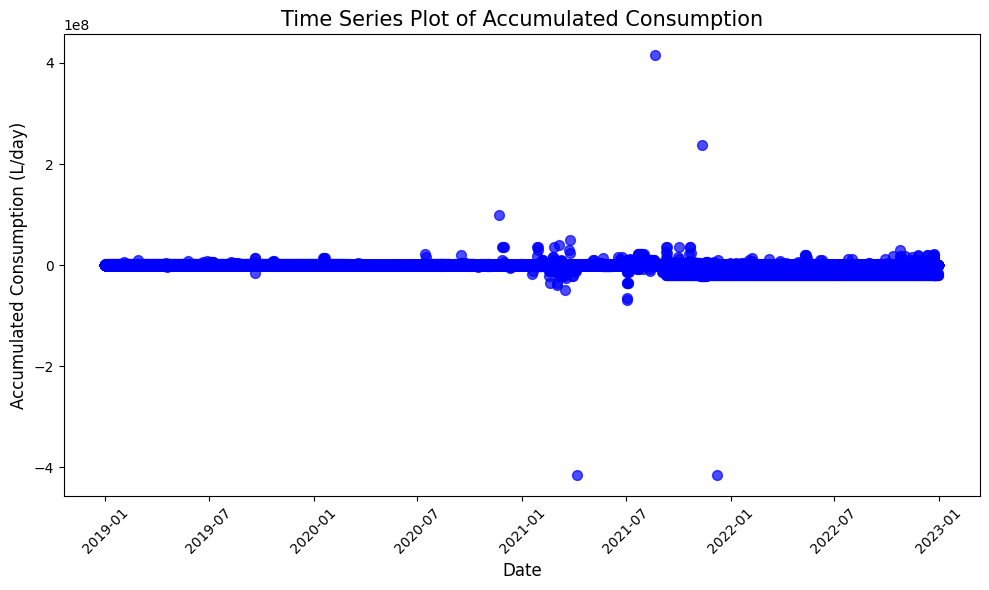

In [6]:
# Accumulated Consumption over Time
dataset_1_act_eco['Data/Fecha/Date'] = pd.to_datetime(dataset_1_act_eco['Data/Fecha/Date'])
plt.figure(figsize=(10, 6))
plt.scatter(dataset_1_act_eco['Data/Fecha/Date'], dataset_1_act_eco['Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)'], color='blue', marker='o', s=50, alpha=0.7, label='Data Points')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accumulated Consumption (L/day)', fontsize=12)
plt.title('Time Series Plot of Accumulated Consumption', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

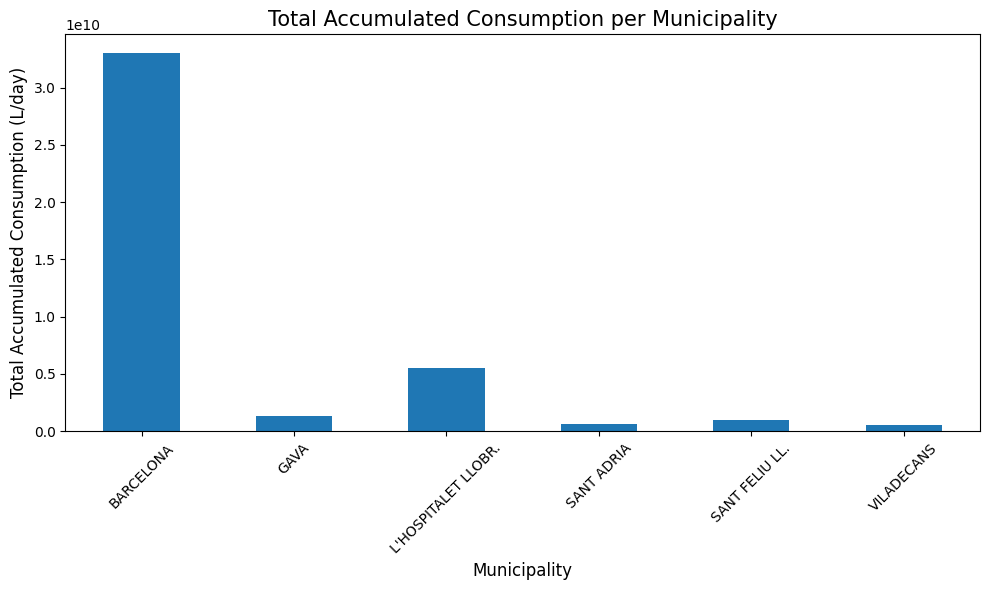

In [7]:
# Aggregate total consumption for each municipality
total_consumption_per_municipality = dataset_1_act_eco.groupby('Municipi/Municipio/Municipality')['Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)'].sum()
total_consumption_per_municipality.plot(kind='bar', figsize=(10,6))
plt.xlabel('Municipality', fontsize=12)
plt.ylabel('Total Accumulated Consumption (L/day)', fontsize=12)
plt.title('Total Accumulated Consumption per Municipality', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

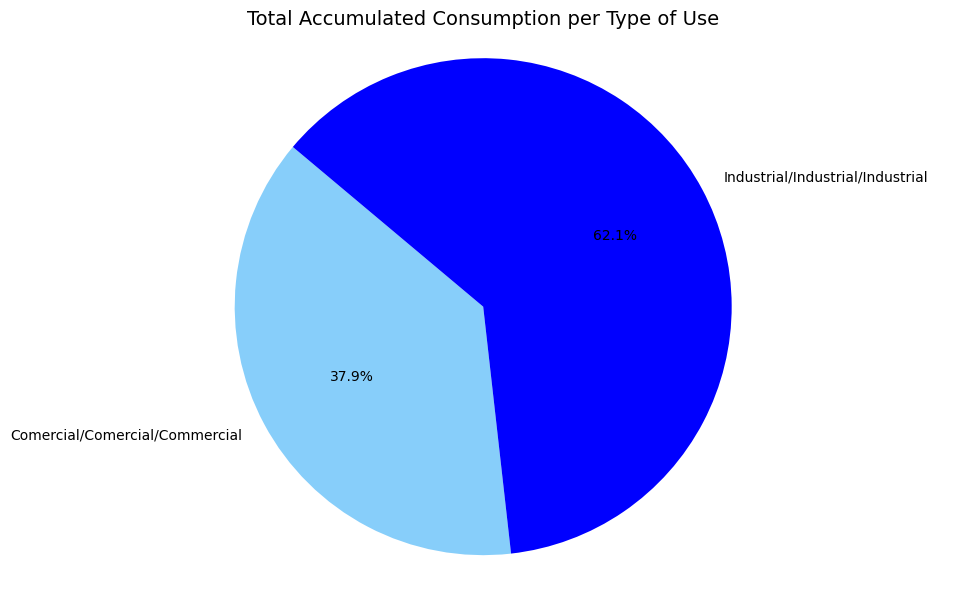

In [8]:
# Aggregate total consumption for each type of use
total_consumption_per_use = dataset_1_act_eco.groupby('Ús/Uso/Use')['Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)'].sum()
plt.figure(figsize=(10, 6))
total_consumption_per_use.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightskyblue', 'blue', 'cornflowerblue'])
plt.title('Total Accumulated Consumption per Type of Use', fontsize=14)
plt.ylabel(None)
plt.tight_layout()
plt.axis('equal')
plt.show()

**Insights:**
- Negative consumption values are considered as incorrect values for the Cumulative Consumption (L/day) column. Consumption has to be positive.
- The number of meters ('Number of meters') varies greatly, with some locations having just one meter and others up to 394 meters.
- In the scatter plot we can clearly see outliers that will be removed later on.
- Most of the consumption is accumulated in the Municipality of Barcelona and it's of Industrial use.

## 2. Data Preprocessing

##### **2.1. Data Transformation**

In [9]:
# Rename dataset_1_activitat_eco_v2 columns
new_column_names = {
    'Districte/Distrito/District': 'District',
    'Codi postal/Código postal/Postcode': 'Postcode',
    'Municipi/Municipio/Municipality': 'Municipality',
    'Data/Fecha/Date': 'Date',
    'Ús/Uso/Use': 'Use',
    "Tipus d'activitat econòmica/Tipo de actividad económica/Type of economic activity": 'Type of economic activity',
    'Nombre de comptadors/Número de contadores/Number of meters': 'Number of meters',
    'Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated Consumption (L/day)': 'Accumulated Consumption (L/day)'
}

dataset_1_act_eco.rename(columns=new_column_names, inplace=True)

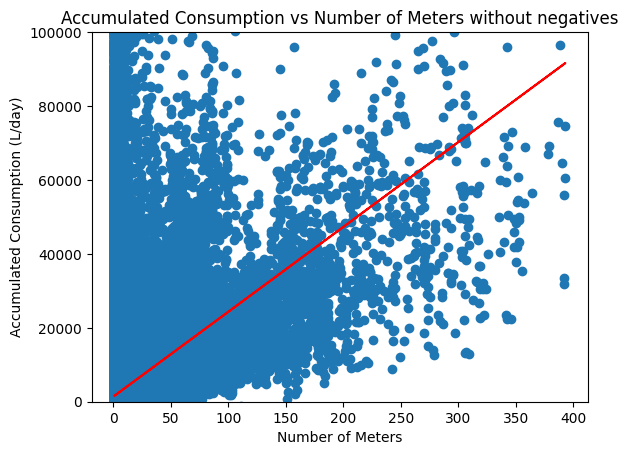

In [10]:
# Randomly sample 700000 data points
sampled_indices = np.random.choice(len(dataset_1_act_eco), size=700000, replace=False)
sampled_data = dataset_1_act_eco.iloc[sampled_indices]

# Scatter Plot for Accumulated Consumption vs Number of Meters without negatives
plt.scatter(sampled_data['Number of meters'], sampled_data['Accumulated Consumption (L/day)'])
plt.title('Accumulated Consumption vs Number of Meters without negatives')
plt.xlabel('Number of Meters')
plt.ylabel('Accumulated Consumption (L/day)')
plt.ylim(0, 100000)

# Calculate the trend line
x = sampled_data['Number of meters']
y = sampled_data['Accumulated Consumption (L/day)']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

plt.show()

We cannot assure that consumption is not normalized, but according to the plots above it does not look like it therefore, they have to be normalized. We will divide the Accumulated Consumption by the Number of Meters in order to obtain the Accumulated Consumption for a single Meter.

In [11]:
# Normalization of Accumulated Consumption (L/day) by Number of meters
dataset_1_act_eco['Normalized Accumulated Consumption (L/day)'] = round(dataset_1_act_eco['Accumulated Consumption (L/day)'] / dataset_1_act_eco['Number of meters'], 3)
dataset_1_act_eco.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day)
0,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,1.0,1.0
1,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0
2,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,84.0,84.0
3,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0
4,NaN,8001,BARCELONA,2019-01-03,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,134.0,134.0


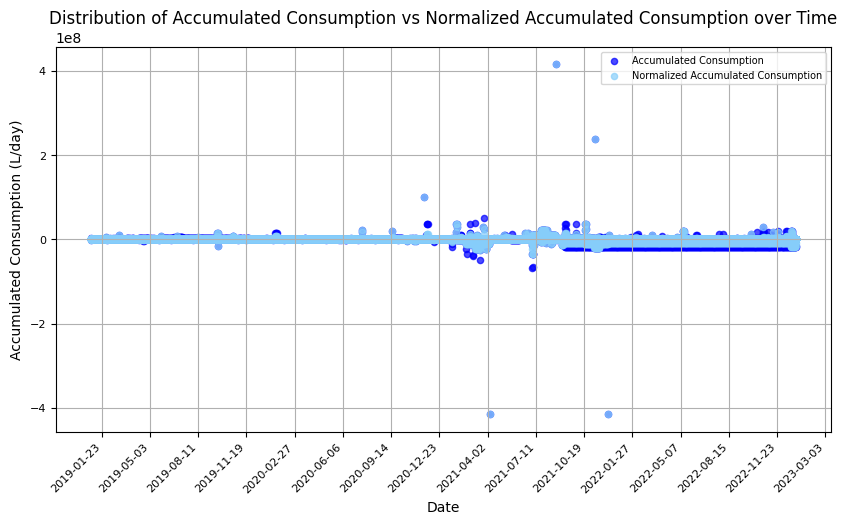

In [12]:
# Distribution of normalized vs non normalized
plt.figure(figsize=(10, 5))
plt.scatter(dataset_1_act_eco["Date"], dataset_1_act_eco["Accumulated Consumption (L/day)"], color='blue',  marker='o', s=20, alpha=0.7, label='Accumulated Consumption')
plt.scatter(dataset_1_act_eco["Date"], dataset_1_act_eco["Normalized Accumulated Consumption (L/day)"], color='lightskyblue',  marker='o', s=20, alpha=0.7, label='Normalized Accumulated Consumption')
plt.title("Distribution of Accumulated Consumption vs Normalized Accumulated Consumption over Time", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Accumulated Consumption (L/day)", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.legend(fontsize=7)
tick_frequency = 100
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tick_frequency))
plt.show()

In [13]:
dataset_1_act_eco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20495388 entries, 0 to 20495387
Data columns (total 9 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   District                                    float64       
 1   Postcode                                    int64         
 2   Municipality                                object        
 3   Date                                        datetime64[ns]
 4   Use                                         object        
 5   Type of economic activity                   object        
 6   Number of meters                            int64         
 7   Accumulated Consumption (L/day)             float64       
 8   Normalized Accumulated Consumption (L/day)  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 1.4+ GB


##### **2.2. Null Values**

In [14]:
# Null values per column
columns_dataset_1_act_eco = dataset_1_act_eco.columns
for column in columns_dataset_1_act_eco:
  print("Column:", column, "- Null values: ", dataset_1_act_eco[column].isnull().sum())

Column: District - Null values:  304581
Column: Postcode - Null values:  0
Column: Municipality - Null values:  0
Column: Date - Null values:  0
Column: Use - Null values:  0
Column: Type of economic activity - Null values:  0
Column: Number of meters - Null values:  0
Column: Accumulated Consumption (L/day) - Null values:  0
Column: Normalized Accumulated Consumption (L/day) - Null values:  0


##### **2.3. Wrong Values**

Now we want to identify the erroneous values in our data. We consider as wrong values the negative consumptions. We will store those values for later analysis.

In [15]:
# We identify negative values in consumption
num_negative_consum_rows = len(dataset_1_act_eco[dataset_1_act_eco['Normalized Accumulated Consumption (L/day)'] < 0])
print("Negative in 'Accumulated Consumption (L/day)' in the dataset:", num_negative_consum_rows)

Negative in 'Accumulated Consumption (L/day)' in the dataset: 32591


In [16]:
# Copy the negative values into the anomalies dataset for later analysis
anomalies = dataset_1_act_eco[dataset_1_act_eco['Normalized Accumulated Consumption (L/day)'] < 0].copy()
anomalies.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day)
3589,NaN,8001,BARCELONA,2021-05-31,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
3926,NaN,8001,BARCELONA,2021-07-18,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
3942,NaN,8001,BARCELONA,2021-07-20,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
4022,NaN,8001,BARCELONA,2021-07-30,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
4102,NaN,8001,BARCELONA,2021-08-09,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0


In [17]:
# Replace negative values in Normalized Accumulated Consumption (L/day) by null
dataset_1_act_eco_1 = dataset_1_act_eco.copy()
dataset_1_act_eco_1.loc[dataset_1_act_eco_1['Normalized Accumulated Consumption (L/day)'] < 0, 'Normalized Accumulated Consumption (L/day)'] = np.nan

# Let's put null also the values of the Accumulated Consumption (L/day)
dataset_1_act_eco_1.loc[dataset_1_act_eco_1['Accumulated Consumption (L/day)'] < 0, 'Accumulated Consumption (L/day)'] = np.nan

# Number of negative values in Normalized Accumulated Consumption (L/day) after removing negative values
num_negative_consum_rows2 = len(dataset_1_act_eco_1[dataset_1_act_eco_1['Normalized Accumulated Consumption (L/day)'] < 0])
print("Negative in 'Normalized Accumulated Consumption (L/day)' in the dataset:", num_negative_consum_rows2)

# Number of null values in Normalized Accumulated Consumption (L/day) after removing negative values
print("Number of Nulls in the dataset without negative values:", dataset_1_act_eco_1['Normalized Accumulated Consumption (L/day)'].isnull().sum())

Negative in 'Normalized Accumulated Consumption (L/day)' in the dataset: 0
Number of Nulls in the dataset without negative values: 32591


##### **2.4. Outliers**

In [18]:
# Treatment of outliers in Normalized Accumulated Consumption (L/day) with the IQR method

# We separate according to USE: Industrial, Domestic or Commercial
domestic_df = dataset_1_act_eco_1[dataset_1_act_eco_1['Use'].str.contains('Domèstic', case=False, na=False)].copy()
industrial_df = dataset_1_act_eco_1[dataset_1_act_eco_1['Use'].str.contains('Industrial', case=False, na=False)].copy()
comercial_df = dataset_1_act_eco_1[dataset_1_act_eco_1['Use'].str.contains('Comercial', case=False, na=False)].copy()

def outliers_iqr(dataframe):
    global anomalies

    # We compute the IQR for the 'Consumption' column
    consum_col = 'Normalized Accumulated Consumption (L/day)'
    Q1 = dataframe[consum_col].quantile(0.25)
    Q3 = dataframe[consum_col].quantile(0.75)
    IQR = Q3 - Q1

    # We identify the outliers
    outlier_filter = ((dataframe[consum_col] < (Q1 - 1.5 * IQR)) | (dataframe[consum_col] > (Q3 + 1.5 * IQR)))

    # Copy the outlier value into the anomalies dataset for later analysis
    outliers = dataframe[outlier_filter].copy()
    anomalies = pd.concat([anomalies, outliers], ignore_index=True)

    # And replace them with null
    dataframe.loc[outlier_filter, consum_col] = np.nan

    return dataframe

# We apply the function for each dataframe corresponding to each "Use"
domestic_df = outliers_iqr(domestic_df)
industrial_df = outliers_iqr(industrial_df)
comercial_df = outliers_iqr(comercial_df)

dataset_1_act_eco_filtered = pd.concat([domestic_df, industrial_df, comercial_df], ignore_index=True)

In [19]:
# Let's put to null also the values that correspond to those outliers in 'Accumulated Consumption (L/day)'
dataset_1_act_eco_filtered.loc[dataset_1_act_eco_filtered['Normalized Accumulated Consumption (L/day)'].isnull(), 'Accumulated Consumption (L/day)'] = np.nan

In [20]:
anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373293 entries, 0 to 2373292
Data columns (total 9 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   District                                    float64       
 1   Postcode                                    int64         
 2   Municipality                                object        
 3   Date                                        datetime64[ns]
 4   Use                                         object        
 5   Type of economic activity                   object        
 6   Number of meters                            int64         
 7   Accumulated Consumption (L/day)             float64       
 8   Normalized Accumulated Consumption (L/day)  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 163.0+ MB


In [21]:
# Number of null values in Normalized Accumulated Consumption (L/day) prior to removing outliers
print("Number of Nulls in the dataset with outliers but no negatives:", dataset_1_act_eco_1['Normalized Accumulated Consumption (L/day)'].isnull().sum())        #dataset with outliers

# Number of null values in Normalized Accumulated Consumption (L/day) after removing outliers
print("Number of Nulls in the dataset without outliers nor negatives:", dataset_1_act_eco_filtered['Normalized Accumulated Consumption (L/day)'].isnull().sum())   #dataset without outliers

Number of Nulls in the dataset with outliers but no negatives: 32591
Number of Nulls in the dataset without outliers nor negatives: 2373293


##### **2.5. Storage of Anomalies**

If all anomalies in the data have been cleaned correctly we should have the sum of the number of outlier values and negatives remaining in our anomalies stored.

Negative values removed = 32591

Outliers removed = 2373293 - 32591 = 2340702

Total number of anomalies = 2373293

In [22]:
# Save current clean dataset for classification of anomalies
clean_data = dataset_1_act_eco_filtered.copy()

anomalies.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day)
0,NaN,8001,BARCELONA,2021-05-31,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
1,NaN,8001,BARCELONA,2021-07-18,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
2,NaN,8001,BARCELONA,2021-07-20,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
3,NaN,8001,BARCELONA,2021-07-30,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0
4,NaN,8001,BARCELONA,2021-08-09,Industrial/Industrial/Industrial,"* Productes alimentaris, begudes i tabac/ * Pr...",1,-1.0,-1.0


## 3. Data Enhancement

In [23]:
# Convert "Date" column to datetime
dataset_1_act_eco_filtered['Date'] = pd.to_datetime(dataset_1_act_eco_filtered['Date'])
dataset_1_act_eco_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20495388 entries, 0 to 20495387
Data columns (total 9 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   District                                    float64       
 1   Postcode                                    int64         
 2   Municipality                                object        
 3   Date                                        datetime64[ns]
 4   Use                                         object        
 5   Type of economic activity                   object        
 6   Number of meters                            int64         
 7   Accumulated Consumption (L/day)             float64       
 8   Normalized Accumulated Consumption (L/day)  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 1.4+ GB


In [24]:
# We create a new "Season" column based on the "Date" column
def map_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

dataset_1_act_eco_filtered['Season'] = dataset_1_act_eco_filtered['Date'].dt.month.map(map_to_season)

# We create a new column "Day_of_Week" based on the column "Date"
dataset_1_act_eco_filtered['Day of Week'] = dataset_1_act_eco_filtered['Date'].dt.day_name()

# We create a new column "Month" based on the column "Date"
dataset_1_act_eco_filtered['Month'] = dataset_1_act_eco_filtered['Date'].dt.month

# We create a new column "Year" based on the column "Date"
dataset_1_act_eco_filtered['Year'] = dataset_1_act_eco_filtered['Date'].dt.year

dataset_1_act_eco_filtered.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day),Season,Day of Week,Month,Year
0,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,1.0,1.0,Winter,Tuesday,1,2019
1,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0,Winter,Tuesday,1,2019
2,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,84.0,84.0,Winter,Wednesday,1,2019
3,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0,Winter,Wednesday,1,2019
4,NaN,8001,BARCELONA,2019-01-03,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,134.0,134.0,Winter,Thursday,1,2019


As we can see now all data in this dataset ranges from years 2019 to 2022. This is important as now we are going to add new information from other datasets and we are going to need the dates to match.

In [25]:
dataset_1_act_eco_filtered['Year'].unique()

array([2019, 2020, 2021, 2022], dtype=int64)

Lets add information to the dataset about the precipitations in Barcelona for the dates of each entrie as well as information about the temperatures. Both precipitation and temperatures should have a strong correlation with the consumed water.

In [26]:
# Change your path of the data if necessary
dataset_rain = 'C:/Users/edith/Desktop/TFG/Datasets/OpenDataBCN/precipitacionsbcndesde1786_2023_long.csv'
dataset_rain = pd.read_csv(dataset_rain)
dataset_rain.head()

,Any,Mes,Desc_Mes,Precipitacions
0,1786,1,Gener,32.8
1,1786,2,Febrer,28.4
2,1786,3,Març,84.4
3,1786,4,Abril,42.3
4,1786,5,Maig,8.5


In [27]:
# Filter the dataset to keep only the desired years
years_to_keep = [2019, 2020, 2021, 2022]
dataset_rain = dataset_rain[dataset_rain['Any'].isin(years_to_keep)]

# Display the first few rows of the filtered dataset
dataset_rain.head()

,Any,Mes,Desc_Mes,Precipitacions
2796,2019,1,Gener,18.2
2797,2019,2,Febrer,4.6
2798,2019,3,Març,0.3
2799,2019,4,Abril,36.2
2800,2019,5,Maig,109.0


In [28]:
def map_to_precipitation(dataset_filtered, dataset_rain):

    # Merge datasets on 'Year' and 'Month'
    merged_data = pd.merge(dataset_filtered, dataset_rain, left_on=['Year', 'Month'], right_on=['Any', 'Mes'], how='left')

    # Drop unnecessary columns from the merged dataset
    merged_data.drop(['Any', 'Mes', 'Desc_Mes'], axis=1, inplace=True)

    return merged_data

dataset_1_act_eco_filtered = map_to_precipitation(dataset_1_act_eco_filtered, dataset_rain)
dataset_1_act_eco_filtered.rename(columns = {'Precipitacions': 'Precipitations'}, inplace=True)
dataset_1_act_eco_filtered.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day),Season,Day of Week,Month,Year,Precipitations
0,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,1.0,1.0,Winter,Tuesday,1,2019,18.2
1,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0,Winter,Tuesday,1,2019,18.2
2,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,84.0,84.0,Winter,Wednesday,1,2019,18.2
3,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0,Winter,Wednesday,1,2019,18.2
4,NaN,8001,BARCELONA,2019-01-03,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,134.0,134.0,Winter,Thursday,1,2019,18.2


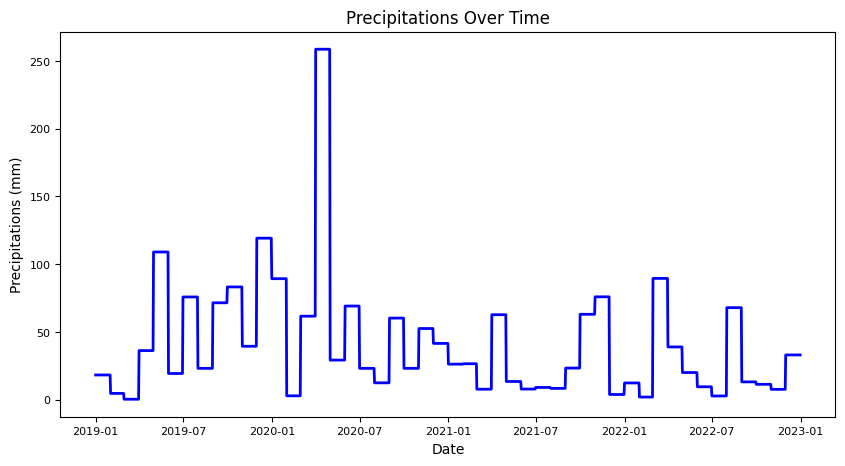

In [29]:
# Precipitation Over Time
df_sorted = dataset_1_act_eco_filtered.sort_values(by='Date')
plt.figure(figsize=(10, 5))
plt.plot(df_sorted['Date'], df_sorted['Precipitations'], color='blue', linewidth=2)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Precipitations (mm)', fontsize=10)
plt.title('Precipitations Over Time', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [30]:
# Change your path of the data if necessary
dataset_temp = 'C:/Users/edith/Desktop/TFG/Datasets/OpenDataBCN/temperaturesbcndesde1780_2023_long.csv'
dataset_temp = pd.read_csv(dataset_temp)
dataset_temp.head()

,Any,Mes,Desc_Mes,Temperatura
0,1780,1,Gener,6.7
1,1780,2,Febrer,7.3
2,1780,3,Març,11.6
3,1780,4,Abril,11.4
4,1780,5,Maig,16.3


In [31]:
# Filter the dataset to keep only the desired years
years_to_keep = [2019, 2020, 2021, 2022]
dataset_temp = dataset_temp[dataset_temp['Any'].isin(years_to_keep)]

# Display the first few rows of the filtered dataset
dataset_temp.head()

,Any,Mes,Desc_Mes,Temperatura
2868,2019,1,Gener,8.1
2869,2019,2,Febrer,11.9
2870,2019,3,Març,13.5
2871,2019,4,Abril,13.4
2872,2019,5,Maig,15.6


In [32]:
def map_to_temperature(dataset_filtered, dataset_temp):

    # Merge datasets on 'Year' and 'Month'
    merged_data = pd.merge(dataset_filtered, dataset_temp, left_on=['Year', 'Month'], right_on=['Any', 'Mes'], how='left')

    # Drop unnecessary columns from the merged dataset
    merged_data.drop(['Any', 'Mes', 'Desc_Mes'], axis=1, inplace=True)

    return merged_data

dataset_1_act_eco_filtered = map_to_temperature(dataset_1_act_eco_filtered, dataset_temp)
dataset_1_act_eco_filtered.rename(columns = {'Temperatura': 'Temperature'}, inplace=True)
dataset_1_act_eco_filtered.head()

,District,Postcode,Municipality,Date,Use,Type of economic activity,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day),Season,Day of Week,Month,Year,Precipitations,Temperature
0,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,1.0,1.0,Winter,Tuesday,1,2019,18.2,8.1
1,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0,Winter,Tuesday,1,2019,18.2,8.1
2,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,84.0,84.0,Winter,Wednesday,1,2019,18.2,8.1
3,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,<NULL>/ <NULL>/ <NULL>,1,0.0,0.0,Winter,Wednesday,1,2019,18.2,8.1
4,NaN,8001,BARCELONA,2019-01-03,Industrial/Industrial/Industrial,* d'altres categories/ * de otras categorías/ ...,1,134.0,134.0,Winter,Thursday,1,2019,18.2,8.1


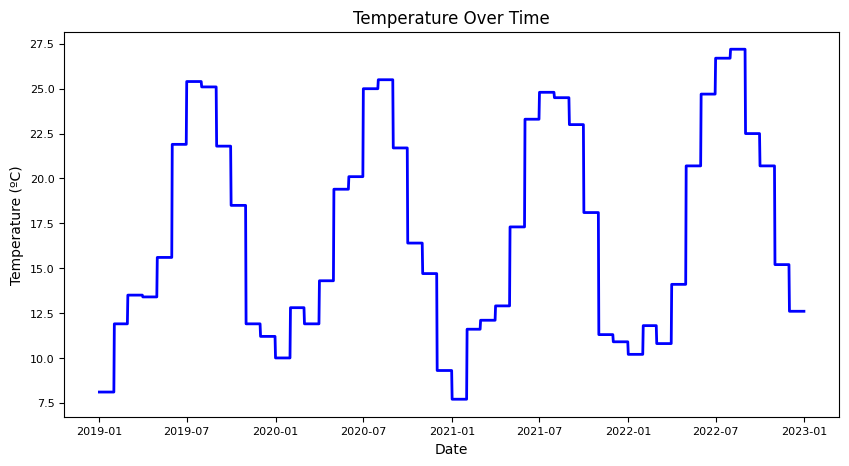

In [33]:
# Temperature Over Time
df_sorted = dataset_1_act_eco_filtered.sort_values(by='Date')
plt.figure(figsize=(10, 5))
plt.plot(df_sorted['Date'], df_sorted['Temperature'], color='blue', linewidth=2)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Temperature (ºC)', fontsize=10)
plt.title('Temperature Over Time', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

## 4. Data Prediction

In order to do the projection of incorrect values (negative and outliers) that right now happen to be null values in the dataset, we will implement several data prediction models, compare their results and conclude which gives the best results for our data.

We will now encode the variables that aren't numerical in order to work with them and plot a correlation matrix to see which features explain best our target variable, Accumulated Consumption (L/day).

In [34]:
# Convert "Date" column to object for label encoding
dataset_1_act_eco_filtered['Date'] = dataset_1_act_eco_filtered['Date'].astype(object)

In [ ]:
# Label Encoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each column containing categorical data
for column in dataset_1_act_eco_filtered.columns:
    if dataset_1_act_eco_filtered[column].dtype == 'object':
        dataset_1_act_eco_filtered[column] = label_encoder.fit_transform(dataset_1_act_eco_filtered[column])

In [ ]:
# We remove the null values in to see the correct correlation of the data
dataset_1_act_eco_filtered = dataset_1_act_eco_filtered.dropna(subset = ['District'])

dataset_filtered_not_null = dataset_1_act_eco_filtered[~dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'].isnull()]
corr = dataset_filtered_not_null.corr()
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 12})
plt.show()

In [ ]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset_1_act_eco_filtered2 = dataset_1_act_eco_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Independent variables
features = ['Use', 'Number of meters', 'Postcode', 'Municipality', 'District']

X = dataset_1_act_eco_filtered2[features]

# Target variable (dependent variable)
y = dataset_1_act_eco_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

##### **4.1. Linear Regression**

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Evalute the model
mse_lr = mean_squared_error(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error (MSE): {round(np.sqrt(mse_lr), 4)}")
print(f"Linear Regression Mean Absolute Error (MAE): {round(mae_lr, 4)}")
print(f"Linear Regression R-squared (R2): {round(r2_lr, 4)}")

##### **4.2. Random Forest**

In [ ]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset_1_act_eco_filtered2 = dataset_1_act_eco_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Reduce the working dataset
rows = len(dataset_1_act_eco_filtered2) // 5
dataset_1_act_eco_filtered2 = dataset_1_act_eco_filtered2.iloc[:rows]

# Independent variables
features = ['Use', 'Number of meters', 'Postcode', 'Municipality', 'District']
X = dataset_1_act_eco_filtered2[features]

# Target variable (dependent variable)
y = dataset_1_act_eco_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

In [ ]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error (MSE):", round(np.sqrt(mse_rf), 4))
print(f"Random Forest Mean Absolute Error (MAE): {round(mae_rf, 4)}")
print(f"Random Forest R-squared (R2):", round(r2_rf, 4))

##### **4.3. XGBoost**

In [ ]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset_1_act_eco_filtered2 = dataset_1_act_eco_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Independent variables
features = ['Use', 'Number of meters', 'Postcode', 'Municipality', 'District']

X = dataset_1_act_eco_filtered2[features]

# Target variable (dependent variable)
y = dataset_1_act_eco_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

In [ ]:
# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Squared Error (MSE):", round(np.sqrt(mse_xgb), 4))
print(f"XGBoost Mean Absolute Error (MAE): {round(mae_xgb, 4)}")
print(f"XGBoost R-squared (R2):", round(r2_xgb, 4))

##### **4.4. K-Nearest Neighbors**

In [ ]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset_1_act_eco_filtered2 = dataset_1_act_eco_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Reduce the working dataset
rows = len(dataset_1_act_eco_filtered2) // 5
dataset_1_act_eco_filtered2 = dataset_1_act_eco_filtered2.iloc[:rows]

# Independent variables
features = ['Use', 'Number of meters', 'Postcode', 'Municipality', 'District']
X = dataset_1_act_eco_filtered2[features]

# Target variable (dependent variable)
y = dataset_1_act_eco_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

In [ ]:
# K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"K-Nearest Neighbors Mean Squared Error (MSE):", round(np.sqrt(mse_knn), 4))
print(f"K-Nearest Neighbors Mean Absolute Error (MAE): {round(mae_knn, 4)}")
print(f"K-Nearest Neighbors R-squared (R2):", round(r2_knn, 4))

##### **4.5. Support Vector Machine**

In [ ]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset_1_act_eco_filtered2 = dataset_1_act_eco_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Reduce the working dataset
rows = len(dataset_1_act_eco_filtered2) // 100
dataset_1_act_eco_filtered2 = dataset_1_act_eco_filtered2.iloc[:rows]

# Independent variables
features = ['Use', 'Number of meters', 'Postcode', 'Municipality', 'District']
X = dataset_1_act_eco_filtered2[features]

# Target variable (dependent variable)
y = dataset_1_act_eco_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

In [ ]:
# Support Vector Machine
svm_model = SVR()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print(f"Support Vector Machine Mean Squared Error (MSE):", round(np.sqrt(mse_svm), 4))
print(f"Support Vector Machine Mean Absolute Error (MAE): {round(mae_svm, 4)}")
print(f"Support Vector Machine R-squared (R2):", round(r2_svm, 4))

##### **4.6. Conclusions on Data Prediction Algorithms**

Based on the R-squared values obtained per each model I conclude that ??? is the most accurate for dataset1_v2.csv data. It is considered a good model if the R-squared value is higher than 0.9. Therefore now we will replace the missing values with the predictions of this model. We have already trained model so now we replace all null values.

In [ ]:
# Identifiquem les files amb valor Null en 'Normalized Consum acumulat (L/dia)'
missing_rows = dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'].isnull()]

features2 = ['Use', 'Number of meters', 'Postcode', 'Municipality', 'District']
X_ = missing_rows[features2]

# Predim els valors amb el model
predicted_values = xgb_model.predict(X_)

dataset_1_act_eco_filtered.loc[missing_rows.index, 'Accumulated Consumption (L/day)'] = predicted_values

We now check that no null values nor negatives are in the dataset.

In [ ]:
# Number of null values in Accumulated Consumption (L/day)
print("Number of Nulls in the dataset:", dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'].isnull().sum())

# Number of negatives values in Accumulated Consumption (L/day)
print("Number of Negatives in the dataset:", len(dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'] < 0]))

In order to keep working with our normalized values lets once again put all null values in 'Normalized Accumulated Consumption (L/day)' by diving the consumption by the number of meters.

In [ ]:
predicted_values = dataset_1_act_eco_filtered['Accumulated Consumption (L/day)'] / dataset_1_act_eco_filtered['Number of meters']

dataset_1_act_eco_filtered.loc[dataset_1_act_eco_filtered['Normalized Accumulated Consumption (L/day)'].isnull(), 'Normalized Accumulated Consumption (L/day)'] = predicted_values

In [ ]:
# Number of null values in Normalized Accumulated Consumption (L/day)
print("Number of Nulls in the dataset:", dataset_1_act_eco_filtered['Normalized Accumulated Consumption (L/day)'].isnull().sum())

# Number of negatives values in Normalized Accumulated Consumption (L/day)
print("Number of Negatives in the dataset:", len(dataset_1_act_eco_filtered[dataset_1_act_eco_filtered['Normalized Accumulated Consumption (L/day)'] < 0]))

Lets visualize the Consumption after having cleaned and projected the incorrect values.

In [ ]:
# PLOTS

## 5. Analysis of anomalies

##### **5.1. Classification Criteria**

Previously, we stored all anomalies for later analysis. We are now going to state a classification criteria in order to classify said anomalies into 3 categories: leak or waste, system error or correct but misclassified.
This classification is based on the average of the correct real data, I'm not using the predicted one by the models but it might not be very accurate. This should be done with specific data portraying leaks, waste and system errors.

In [ ]:
# Count of Outliers and Negative values
outliers_count = (anomalies['Normalized Accumulated Consumption (L/day)'] > 0).sum()
negative_count = (anomalies['Normalized Accumulated Consumption (L/day)'] < 0).sum()

total_count = len(anomalies)
outliers_percentage = (outliers_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100

labels = ['Outliers', 'Negative Consumption']
sizes = [outliers_percentage, negative_percentage]
colors = ['cornflowerblue', 'lightskyblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Outliers and Negative Consumption')
plt.axis('equal')
plt.show()

Now we compute the minimum, average and maximum values per type of Use so we can classify each values accordingly.

In [ ]:
# For each type of Use we can compute the min, average and max values
grouped_data = clean_data.groupby('Use')['Normalized Accumulated Consumption (L/day)'].agg(['min', 'mean', 'max'])

# Accessing min, average, and max values for a specific 'Use' type
use_type = 'Domèstic/Doméstico/Domestic'
domestic_min = grouped_data.loc[use_type, 'min']
domestic_average = grouped_data.loc[use_type, 'mean']
domestic_max = grouped_data.loc[use_type, 'max']

use_type = 'Comercial/Comercial/Commercial'
commercial_min = grouped_data.loc[use_type, 'min']
commercial_average = grouped_data.loc[use_type, 'mean']
commercial_max = grouped_data.loc[use_type, 'max']

use_type = 'Industrial/Industrial/Industrial'
industrial_min = grouped_data.loc[use_type, 'min']
industrial_average = grouped_data.loc[use_type, 'mean']
industrial_max = grouped_data.loc[use_type, 'max']

grouped_data

##### **5.2. Anomalies classification**

The following function gets the anomalies dataset and depending on the type of Use applies a classification. I considered consumption values over the maximum value to be of type 'Leak or Waste'. If the consumption is negative then I consider this a 'Data Collection System Error' and in case of not belonging in any of these two groups then the value would be 'Correct but Misclassified'.

In [ ]:
def anomalies_classification(dataset_anomalies):
    if dataset_anomalies['Use'] == 'Domèstic/Doméstico/Domestic':
        if dataset_anomalies['Normalized Accumulated Consumption (L/day)'] > domestic_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Normalized Accumulated Consumption (L/day)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
        
    elif dataset_anomalies['Use'] == 'Comercial/Comercial/Commercial':
        if dataset_anomalies['Normalized Accumulated Consumption (L/day)'] > commercial_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Normalized Accumulated Consumption (L/day)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
        
    elif dataset_anomalies['Use'] == 'Industrial/Industrial/Industrial':
        if dataset_anomalies['Normalized Accumulated Consumption (L/day)'] > industrial_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Normalized Accumulated Consumption (L/day)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
    

anomalies['Classification'] = anomalies.apply(anomalies_classification, axis=1)
anomalies.head()

Now we can visualize the new classification in total and per type of Use.

In [ ]:
# Count occurrences of each classification
classification_counts = anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Total Percentage of Each Anomaly Classification')
plt.axis('equal')
plt.show()

In [ ]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Domèstic/Doméstico/Domestic']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue'] 

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Anomaly Classification for Domestic Use')
plt.axis('equal')
plt.show()

In [ ]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Comercial/Comercial/Commercial']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Anomaly Classification for Commercial Use')
plt.axis('equal') 
plt.show()

In [ ]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Industrial/Industrial/Industrial']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Anomaly Classification for industrial Use')
plt.axis('equal')
plt.show()

In [ ]:
# Download anomalies
anomalies.to_csv('anomalies_dataset1_activitat_eco_v2.csv', index=False)

## 6. Export improved data

In [ ]:
dataset_1_act_eco_filtered.to_csv('updated_dataset_1_activitat_eco_v2.csv', index=False)